In [ ]:
'''
Preparing the data for the analysis:
-Filtering for transfers only (Movement=In, TransferType=Transfer)
-Excluding reserve teams, youngsters ...
-Creating LeagueInvolved col to know from which league has the transfer been
-Correcting MarketValue growth
-Adding fifa attributes to the train df
-Adding Years col which represents how long the player has been playing in the given team
-Combining train df with graph attributes
-Do the same changes with the prediction set
'''

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
from networkx.algorithms import community
import operator
from itertools import islice
import glob
import os
import pandasql as ps

In [36]:
df = pd.read_excel('/Scripts/world_transfers/df.xlsx')

In [5]:
df.head()

,Unnamed: 0,Club,Name,Age,Nationality,Position,Pos,MarketValue,ClubInvolved,CountryInvolved,Fee,Movement,Season,Window,League,MainPosition,TransferType
0,0,Shakhtar Donetsk,Bernard,20,Brazil,Left Winger,LW,10.0,Clube Atlético Mineiro,Brazil,25.0,In,2013,s,Ukrainian Premier League,Forward,Transfer
1,1,Shakhtar Donetsk,Fred,20,Brazil,Central Midfield,CM,5.0,Sport Club Internacional,Brazil,15.0,In,2013,s,Ukrainian Premier League,Midfielder,Transfer
2,2,Shakhtar Donetsk,Fernando,21,Brazil,Defensive Midfield,DM,10.0,Grêmio Foot-Ball Porto Alegrense,Brazil,11.0,In,2013,s,Ukrainian Premier League,Midfielder,Transfer
3,3,Shakhtar Donetsk,Wellington Nem,21,Brazil,Right Winger,RW,8.0,Fluminense Football Club,Brazil,9.0,In,2013,s,Ukrainian Premier League,Forward,Transfer
4,4,Shakhtar Donetsk,Facundo Ferreyra,22,Argentina,Centre-Forward,CF,6.0,Club Atlético Vélez Sarsfield,Argentina,7.0,In,2013,s,Ukrainian Premier League,Forward,Transfer


In [37]:
df = df[df.TransferType == 'Transfer']

In [38]:
df.TransferType.value_counts()

Transfer    96341
Name: TransferType, dtype: int64

In [39]:
df = df[df.Movement == 'In']
df.Movement.value_counts()

In    52648
Name: Movement, dtype: int64

In [40]:
#exclude transfers without clubs
df = df[~df.CountryInvolved.isin(['Without Club', 'Retired', 'Career break', 'Unknown', 'Ban'])]

In [41]:
#drop unecessary cols
df = df.drop(['Unnamed: 0', 'Position', 'Fee', 'Movement', 'Window', 'TransferType'], axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48789 entries, 0 to 285476
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Club             48789 non-null  object 
 1   Name             48789 non-null  object 
 2   Age              48789 non-null  int64  
 3   Nationality      48781 non-null  object 
 4   Pos              48789 non-null  object 
 5   MarketValue      48789 non-null  float64
 6   ClubInvolved     48787 non-null  object 
 7   CountryInvolved  48789 non-null  object 
 8   Season           48789 non-null  int64  
 9   League           48789 non-null  object 
 10  MainPosition     48789 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.5+ MB


In [43]:
df.Age.describe()

count    48789.000000
mean        22.313144
std          4.034206
min          0.000000
25%         19.000000
50%         22.000000
75%         25.000000
max         42.000000
Name: Age, dtype: float64

In [44]:
#check players under 10
zero = df[df.Age < 10]
zero.head(20)

,Club,Name,Age,Nationality,Pos,MarketValue,ClubInvolved,CountryInvolved,Season,League,MainPosition
9954,Bologna FC 1909,Emilio Badini,0,Italy,midfield,0.000,Bologna Primavera,Italy,2013,Italian Serie A,Midfielder
14510,West Bromwich Albion,Reece Hayes,0,England,AM,0.000,West Bromwich Albion U18,England,2013,English Premier League,Midfielder
38099,Athlétic Club Arlésien,Ismaël Bennacer,0,Algeria,DM,0.000,Athlétic Club Arlésien U19,France,2014,French Ligue 2,Midfielder
66458,Blackpool FC,Curtis Thompson,0,England,midfield,0.000,Blackpool FC U18,England,2012,English League Championship,Midfielder
87090,KV Kortrijk,Edouard de Plancke,0,Belgium,GK,0.000,Cercle Brugge,Belgium,2008,Belgian Jupiler Pro League,Goalkeeper
91474,Olympique Lyon,Daniel Ravier,0,France,midfield,0.000,Olympique Lyon U19,France,2008,French Ligue 1,Midfielder
104064,Cercle Brugge,Edouard de Plancke,0,Belgium,GK,0.000,Club Brugge KV,Belgium,2006,Belgian Jupiler Pro League,Goalkeeper
122843,Cobh Ramblers FC,Sean Daley,0,Ireland,DM,0.000,Cobh Ramblers U19,Ireland,2007,Rep Ireland Airtricity League,Midfielder
143372,NEC Nijmegen,Julian Lamers,0,NaN,DM,0.000,NEC Nijmegen U19,Netherlands,2009,Holland Eredivisie,Midfielder
144532,Bolton Wanderers,Stuart McDonald,0,NaN,CM,0.000,Bolton Wanderers U23,England,2009,English Premier League,Midfielder


In [45]:
df.Age.value_counts()

19    6171
18    5768
20    4663
21    4050
22    3846
23    3724
24    3357
25    3052
26    2690
17    2554
27    2273
28    1735
29    1379
30    1005
31     716
16     633
32     452
33     278
34     160
15     109
35      82
36      39
37      23
0       15
38       7
14       3
40       3
42       1
39       1
Name: Age, dtype: int64

In [46]:
#drop players with age under 10
df = df[df.Age > 10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48774 entries, 0 to 285476
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Club             48774 non-null  object 
 1   Name             48774 non-null  object 
 2   Age              48774 non-null  int64  
 3   Nationality      48768 non-null  object 
 4   Pos              48774 non-null  object 
 5   MarketValue      48774 non-null  float64
 6   ClubInvolved     48772 non-null  object 
 7   CountryInvolved  48774 non-null  object 
 8   Season           48774 non-null  int64  
 9   League           48774 non-null  object 
 10  MainPosition     48774 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.5+ MB


In [50]:
df.sort_values(by='MarketValue', ascending=False)[:20]

,Club,Name,Age,Nationality,Pos,MarketValue,ClubInvolved,CountryInvolved,Season,League,MainPosition
191469,Real Madrid,Eden Hazard,28,Belgium,LW,150.0,Chelsea FC,England,2019,Spain Primera Division,Forward
191431,FC Barcelona,Antoine Griezmann,28,France,SS,130.0,Atlético Madrid,Spain,2019,Spain Primera Division,Forward
240559,Paris Saint-Germain,Kylian Mbappé,19,France,CF,120.0,AS Monaco,France,2018,French Ligue 1,Forward
236933,Juventus FC,Cristiano Ronaldo,33,Portugal,LW,100.0,Real Madrid,Spain,2018,Italian Serie A,Forward
163594,Paris Saint-Germain,Neymar,25,Brazil,LW,100.0,FC Barcelona,Spain,2017,French Ligue 1,Forward
152801,FC Barcelona,Philippe Coutinho,25,Brazil,AM,90.0,Liverpool FC,England,2017,Spain Primera Division,Midfielder
203838,Bayern Munich,Philippe Coutinho,27,Brazil,AM,90.0,FC Barcelona,Spain,2019,German 1 Bundesliga,Midfielder
199834,Inter Milan,Christian Eriksen,27,Denmark,AM,90.0,Tottenham Hotspur,England,2019,Italian Serie A,Midfielder
191432,FC Barcelona,Frenkie de Jong,22,Netherlands,CM,85.0,Ajax Amsterdam,Netherlands,2019,Spain Primera Division,Midfielder
221840,Chelsea FC,Kai Havertz,21,Germany,AM,81.0,Bayer 04 Leverkusen,Germany,2020,English Premier League,Midfielder


In [51]:
#create df to specify LeagueInvolved col
df_league = df[['Club', 'League', 'Season']].drop_duplicates()

In [52]:
#create LeagueInvolved col to know from which league has the transfer been
num = 0
df['LeagueInvolved'] = None
for i, r in df.iterrows():
    num += 1
    df_help = df_league[(df_league['Season'] == r['Season']) & (df_league['Club'] == r['ClubInvolved'])]
    if df_help['League'].any() == False:
        df.at[i,'LeagueInvolved'] = r['CountryInvolved']
    else:
        df.at[i,'LeagueInvolved'] = df_help['League'].to_string(index=False)

    print(f'{num} / {len(df)} ready')

47775 / 48774 ready
47776 / 48774 ready
47777 / 48774 ready
47778 / 48774 ready
47779 / 48774 ready
47780 / 48774 ready
47781 / 48774 ready
47782 / 48774 ready
47783 / 48774 ready
47784 / 48774 ready
47785 / 48774 ready
47786 / 48774 ready
47787 / 48774 ready
47788 / 48774 ready
47789 / 48774 ready
47790 / 48774 ready
47791 / 48774 ready
47792 / 48774 ready
47793 / 48774 ready
47794 / 48774 ready
47795 / 48774 ready
47796 / 48774 ready
47797 / 48774 ready
47798 / 48774 ready
47799 / 48774 ready
47800 / 48774 ready
47801 / 48774 ready
47802 / 48774 ready
47803 / 48774 ready
47804 / 48774 ready
47805 / 48774 ready
47806 / 48774 ready
47807 / 48774 ready
47808 / 48774 ready
47809 / 48774 ready
47810 / 48774 ready
47811 / 48774 ready
47812 / 48774 ready
47813 / 48774 ready
47814 / 48774 ready
47815 / 48774 ready
47816 / 48774 ready
47817 / 48774 ready
47818 / 48774 ready
47819 / 48774 ready
47820 / 48774 ready
47821 / 48774 ready
47822 / 48774 ready
47823 / 48774 ready
47824 / 48774 ready


In [55]:
df.LeagueInvolved.value_counts()[:50]

Italian Serie A                  2429
Italy                            2342
England                          2308
France                           1829
Germany                          1617
Spain                            1568
English Premier League           1267
German 1 Bundesliga              1223
Italian Serie B                  1181
Poland                           1135
French Ligue 1                   1092
Netherlands                      1043
Portugal                         1035
Turkey                           1000
English League Championship       967
Spain Primera Division            951
Croatia                           936
Brazil                            931
Czech Republic                    862
Sweden                            843
Belgian Jupiler Pro League        838
Greece                            815
Belgium                           812
Norway                            802
Romania                           782
Portuguese Liga ZON SAGRES        773
Denmark     

In [70]:
#df = pd.read_excel('/Scripts/transfer_modelling/training_set.xlsx')

In [71]:
#exclude reserve teams
df = df[~df.ClubInvolved.str.contains('U1' ,na=False)]
df = df[~df.ClubInvolved.str.contains('U2' ,na=False)]
df = df[~df.ClubInvolved.str.contains('Reserves' ,na=False)]
df = df[~df.ClubInvolved.str.endswith(' B' ,na=False)]
df = df[~df.ClubInvolved.str.contains(' II' ,na=False)]
df = df[~df.ClubInvolved.str.contains(' Primavera' ,na=False)]

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32623 entries, 0 to 48773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       32623 non-null  int64  
 1   Club             32623 non-null  object 
 2   Name             32623 non-null  object 
 3   Age              32623 non-null  int64  
 4   Nationality      32621 non-null  object 
 5   Pos              32623 non-null  object 
 6   MarketValue      32623 non-null  float64
 7   ClubInvolved     32621 non-null  object 
 8   CountryInvolved  32623 non-null  object 
 9   Season           32623 non-null  int64  
 10  League           32623 non-null  object 
 11  MainPosition     32623 non-null  object 
 12  LeagueInvolved   32623 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 3.5+ MB


In [75]:
#df.to_excel('/Scripts/transfer_modelling/training_set.xlsx', encoding = 'UTF-8')

Correcting MarketValue

In [83]:
#avg market values
s = df[['Season', 'MarketValue']].groupby('Season').mean()

In [92]:
s

,MarketValue
Season,
2006,1.078304
2007,1.183489
2008,1.436367
2009,1.621395
2010,1.705873
2011,1.843915
2012,1.956545
2013,2.180745
2014,2.158960


<AxesSubplot:xlabel='Season'>

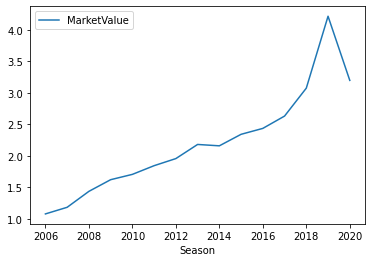

In [93]:
s.plot.line()

<AxesSubplot:xlabel='Season'>

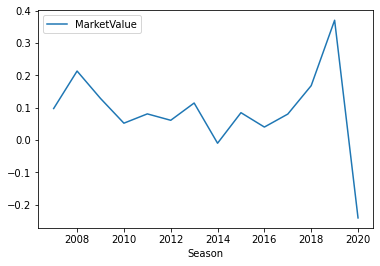

In [94]:
s.pct_change().plot.line()

In [95]:
#75th quantile
q = df[['Season', 'MarketValue']].groupby('Season').quantile(.75)
q

,MarketValue
Season,
2006,0.95
2007,1.20
2008,1.50
2009,1.60
2010,1.50
2011,2.00
2012,2.00
2013,2.00
2014,2.00


In [96]:
q.pct_change()

,MarketValue
Season,
2006,NaN
2007,0.263158
2008,0.250000
2009,0.066667
2010,-0.062500
2011,0.333333
2012,0.000000
2013,0.000000
2014,0.000000


In [123]:
q.values

array([[0.95],
       [1.2 ],
       [1.5 ],
       [1.6 ],
       [1.5 ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.5 ],
       [2.5 ],
       [2.35],
       [2.5 ],
       [3.5 ],
       [2.5 ]])

In [133]:
#create indexes (seasons) for the corr_df
indexes = np.sort(df.Season.unique())

In [140]:
corr_df = pd.DataFrame(data = q.values, index= indexes, columns=['quart'])

In [141]:
corr_df

,quart
2006,0.95
2007,1.20
2008,1.50
2009,1.60
2010,1.50
2011,2.00
2012,2.00
2013,2.00
2014,2.00
2015,2.50


In [146]:
#create CorrMarketValue
num = 0
df['CorrMarketValue'] = None
for i, r in df.iterrows():
    num += 1
    df.at[i,'CorrMarketValue'] = df.at[i,'MarketValue'] / corr_df.at[r['Season'],'quart']
    print(f'{num} / {len(df)} ready')

31624 / 32623 ready
31625 / 32623 ready
31626 / 32623 ready
31627 / 32623 ready
31628 / 32623 ready
31629 / 32623 ready
31630 / 32623 ready
31631 / 32623 ready
31632 / 32623 ready
31633 / 32623 ready
31634 / 32623 ready
31635 / 32623 ready
31636 / 32623 ready
31637 / 32623 ready
31638 / 32623 ready
31639 / 32623 ready
31640 / 32623 ready
31641 / 32623 ready
31642 / 32623 ready
31643 / 32623 ready
31644 / 32623 ready
31645 / 32623 ready
31646 / 32623 ready
31647 / 32623 ready
31648 / 32623 ready
31649 / 32623 ready
31650 / 32623 ready
31651 / 32623 ready
31652 / 32623 ready
31653 / 32623 ready
31654 / 32623 ready
31655 / 32623 ready
31656 / 32623 ready
31657 / 32623 ready
31658 / 32623 ready
31659 / 32623 ready
31660 / 32623 ready
31661 / 32623 ready
31662 / 32623 ready
31663 / 32623 ready
31664 / 32623 ready
31665 / 32623 ready
31666 / 32623 ready
31667 / 32623 ready
31668 / 32623 ready
31669 / 32623 ready
31670 / 32623 ready
31671 / 32623 ready
31672 / 32623 ready
31673 / 32623 ready


In [150]:
df.head()

,Club,Name,Age,Nationality,Pos,MarketValue,ClubInvolved,CountryInvolved,Season,League,MainPosition,LeagueInvolved,CorrMarketValue
0,Shakhtar Donetsk,Bernard,20,Brazil,LW,10.0,Clube Atlético Mineiro,Brazil,2013,Ukrainian Premier League,Forward,Brazil,5.0
1,Shakhtar Donetsk,Fred,20,Brazil,CM,5.0,Sport Club Internacional,Brazil,2013,Ukrainian Premier League,Midfielder,Brazil,2.5
2,Shakhtar Donetsk,Fernando,21,Brazil,DM,10.0,Grêmio Foot-Ball Porto Alegrense,Brazil,2013,Ukrainian Premier League,Midfielder,Brazil,5.0
3,Shakhtar Donetsk,Wellington Nem,21,Brazil,RW,8.0,Fluminense Football Club,Brazil,2013,Ukrainian Premier League,Forward,Brazil,4.0
4,Shakhtar Donetsk,Facundo Ferreyra,22,Argentina,CF,6.0,Club Atlético Vélez Sarsfield,Argentina,2013,Ukrainian Premier League,Forward,Argentina,3.0


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32623 entries, 0 to 48773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Club             32623 non-null  object 
 1   Name             32623 non-null  object 
 2   Age              32623 non-null  int64  
 3   Nationality      32621 non-null  object 
 4   Pos              32623 non-null  object 
 5   MarketValue      32623 non-null  float64
 6   ClubInvolved     32621 non-null  object 
 7   CountryInvolved  32623 non-null  object 
 8   Season           32623 non-null  int64  
 9   League           32623 non-null  object 
 10  MainPosition     32623 non-null  object 
 11  LeagueInvolved   32623 non-null  object 
 12  CorrMarketValue  32623 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 4.5+ MB


In [155]:
df['CorrMarketValue'] = df['CorrMarketValue'].astype(float)

In [156]:
#check the new CorrMarketValue
s = df[['Season', 'CorrMarketValue']].groupby('Season').mean()

In [157]:
s

,CorrMarketValue
Season,
2006,1.135056
2007,0.986241
2008,0.957578
2009,1.013372
2010,1.137249
2011,0.921958
2012,0.978272
2013,1.090373
2014,1.079480


<AxesSubplot:xlabel='Season'>

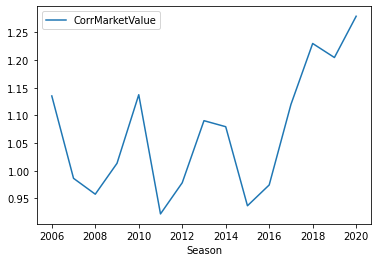

In [158]:
s.plot.line()

Adding fifa attributes to the train df

In [29]:
#import fifa players into one df
all_files = []
path = r'/drivedata/Sofia_players'
for path, subdirs, files in os.walk(path):
    for name in files:
        all_files.append(os.path.join(path, name))
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_fifa_players   = pd.concat(df_from_each_file, ignore_index=True)

In [164]:
df_fifa_players.head()

,ID,Name,Age,Height_cm,Weight_kg,Country,Club,Joined,Position,Foot,...,Standing_tackle,Sliding_tackle,GK_diving,GK_handling,GK_kicking,GK_positioning,GK_reflexes,Value,Wage,Season
0,54050,W. Rooney,20,181cm,78kg,England,Manchester United,NaN,ST,Right,...,42,NaN,11,7,71,11,12,€0,€0,2007
1,1179,G. Buffon,28,191cm,82kg,Italy,Juventus,NaN,GK,Right,...,8,NaN,91,93,76,96,93,€0,€0,2007
2,1747,G. Coupet,33,181cm,80kg,France,Olympique Lyonnais,NaN,GK,Right,...,13,NaN,93,91,82,93,88,€0,€0,2007
3,28130,Ronaldinho,26,181cm,81kg,Brazil,FC Barcelona,NaN,CAM,Right,...,28,NaN,12,10,83,11,10,€0,€0,2007
4,13732,J. Terry,25,183cm,78kg,England,Chelsea,NaN,CB,Right,...,95,NaN,7,8,43,8,12,€0,€0,2007


In [165]:
df_fifa_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244027 entries, 0 to 244026
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                244027 non-null  int64  
 1   Name              244027 non-null  object 
 2   Age               244027 non-null  int64  
 3   Height_cm         244027 non-null  object 
 4   Weight_kg         244027 non-null  object 
 5   Country           244027 non-null  object 
 6   Club              237358 non-null  object 
 7   Joined            187269 non-null  object 
 8   Position          244027 non-null  object 
 9   Foot              244027 non-null  object 
 10  IntReputation     244027 non-null  int64  
 11  Crossing          244027 non-null  int64  
 12  Finishing         244027 non-null  int64  
 13  Heading_accuracy  244027 non-null  int64  
 14  Short_passing     244027 non-null  int64  
 15  Volleys           187269 non-null  float64
 16  Dribbling         24

In [30]:
df_fifa_players['Name'] = df_fifa_players['Name'].str.lstrip()

In [1846]:
#Create different name combinations for joining transfer df to fifa df
df['NewName'] = None
df['LastName'] = None
df['FirstLastName'] = None
num = 0
for i, r in df.iterrows():
    num += 1
    name = df.at[i,'Name']
    if ' ' in name:
        str_pos = name.find(' ')
        first_char = name[0]
        new_name = first_char + '. ' + name[str_pos+1:]
        df.at[i,'NewName'] = new_name

        end_pos = name.rfind(' ')
        df.at[i,'LastName'] = name[end_pos+1:]

        df.at[i,'FirstLastName'] = first_char + '. ' + name[end_pos+1:]
    else:
        df.at[i,'NewName'] = df.at[i,'Name']
        df.at[i,'LastName'] = df.at[i,'Name']
        df.at[i,'FirstLastName'] = df.at[i,'Name']
    print(f'{num} / {len(df)} ready')

31624 / 32623 ready
31625 / 32623 ready
31626 / 32623 ready
31627 / 32623 ready
31628 / 32623 ready
31629 / 32623 ready
31630 / 32623 ready
31631 / 32623 ready
31632 / 32623 ready
31633 / 32623 ready
31634 / 32623 ready
31635 / 32623 ready
31636 / 32623 ready
31637 / 32623 ready
31638 / 32623 ready
31639 / 32623 ready
31640 / 32623 ready
31641 / 32623 ready
31642 / 32623 ready
31643 / 32623 ready
31644 / 32623 ready
31645 / 32623 ready
31646 / 32623 ready
31647 / 32623 ready
31648 / 32623 ready
31649 / 32623 ready
31650 / 32623 ready
31651 / 32623 ready
31652 / 32623 ready
31653 / 32623 ready
31654 / 32623 ready
31655 / 32623 ready
31656 / 32623 ready
31657 / 32623 ready
31658 / 32623 ready
31659 / 32623 ready
31660 / 32623 ready
31661 / 32623 ready
31662 / 32623 ready
31663 / 32623 ready
31664 / 32623 ready
31665 / 32623 ready
31666 / 32623 ready
31667 / 32623 ready
31668 / 32623 ready
31669 / 32623 ready
31670 / 32623 ready
31671 / 32623 ready
31672 / 32623 ready
31673 / 32623 ready


In [1847]:
df.head()

,Club,Name,Age,Nationality,Pos,MarketValue,ClubInvolved,CountryInvolved,Season,League,MainPosition,LeagueInvolved,CorrMarketValue,NewName,LastName,FirstLastName
0,Shakhtar Donetsk,Bernard,20,Brazil,LW,10.0,Clube Atlético Mineiro,Brazil,2013,Ukrainian Premier League,Forward,Brazil,5.0,Bernard,Bernard,Bernard
1,Shakhtar Donetsk,Fred,20,Brazil,CM,5.0,Sport Club Internacional,Brazil,2013,Ukrainian Premier League,Midfielder,Brazil,2.5,Fred,Fred,Fred
2,Shakhtar Donetsk,Fernando,21,Brazil,DM,10.0,Grêmio Foot-Ball Porto Alegrense,Brazil,2013,Ukrainian Premier League,Midfielder,Brazil,5.0,Fernando,Fernando,Fernando
3,Shakhtar Donetsk,Wellington Nem,21,Brazil,RW,8.0,Fluminense Football Club,Brazil,2013,Ukrainian Premier League,Forward,Brazil,4.0,W. Nem,Nem,W. Nem
4,Shakhtar Donetsk,Facundo Ferreyra,22,Argentina,CF,6.0,Club Atlético Vélez Sarsfield,Argentina,2013,Ukrainian Premier League,Forward,Argentina,3.0,F. Ferreyra,Ferreyra,F. Ferreyra


In [1849]:
#change club names to match in both df
df = df.replace('1.FC Nuremberg', '1. FC Nürnberg')
df = df.replace('Olympique Marseille', 'Olympique de Marseille')
df = df.replace('Olympique Lyon', 'Olympique Lyonnais')
df = df.replace('Panathinaikos Athens', 'Panathinaikos FC')
df = df.replace('Chamois Niortais FC', 'Chamois Niortais Football Club')
df = df.replace('S. Kjaer', 'S. Kjær')
df = df.replace('FC Girondins Bordeaux', 'FC Girondins de Bordeaux')
df = df.replace('FC Toulouse', 'Toulouse Football Club')
df = df.replace('Real Betis Balompié', 'Real Betis')
df = df.replace('Olympiacos Piraeus', 'Olympiacos CFP')
df = df.replace('J. II Makoun', 'J. Makoun')
df = df.replace('Stade Reims', 'Stade de Reims')
df = df.replace('M. Albaek', 'M. Albæk')
df = df.replace('FC Évian Thonon Gaillard', 'Évian Thonon Gaillard FC')
df = df.replace('EA Guingamp', 'En Avant de Guingamp')
df = df.replace('J. Moutinho', 'João Moutinho')
df = df.replace('Jagiellonia Bialystok', 'Jagiellonia Białystok')
df = df.replace('FC Nordsjaelland', 'FC Nordsjælland')
df = df.replace('SC Bastia', 'Sporting Club de Bastia')
df = df.replace('SM Caen', 'Stade Malherbe Caen')
df = df.replace('J. Juelsgaard', 'J. Juelsgård')
df = df.replace('J. Luis Palomino', 'J. Palomino')
df = df.replace('1.FC Kaiserslautern', '1. FC Kaiserslautern')
df = df.replace('Udinese', 'Udinese Calcio')
df = df.replace('S. Prcic', 'S. Prcić')
df = df.replace('A. Pesic', 'A. Pešić')
df = df.replace('Barnsley FC', 'Barnsley')
df = df.replace('RC Lens', 'Racing Club de Lens')
df = df.replace('Á. Di María', 'A. Di María')
df = df.replace('LB Châteauroux', 'La Berrichonne de Châteauroux')
df = df.replace('Celta de Vigo', 'RC Celta')
df = df.replace('AS Roma', 'Roma')
df = df.replace('AC Milan', 'Milan')
df = df.replace("G. N'Koudou", 'G. NKoudou')
df = df.replace('Besiktas JK', 'Beşiktaş JK')
df = df.replace('R. Beric', 'R. Berić')
df = df.replace('Rapid Vienna', 'SK Rapid Wien')
df = df.replace('Delfino Pescara 1936', 'Pescara')
df = df.replace('Fulham FC', 'Fulham')
df = df.replace('AS Nancy-Lorraine', 'AS Nancy Lorraine')
df = df.replace('SCO Angers', 'Angers SCO')
df = df.replace('ES Troyes AC', 'ESTAC Troyes')
df = df.replace('O. Selnaes', 'O. Selnæs')
df = df.replace('Stade Brest 29', 'Stade Brestois 29')
df = df.replace('Genclerbirligi Ankara', 'Gençlerbirliği SK')
df = df.replace('FC Internazionale', 'Inter')
df = df.replace('SV Zulte Waregem', 'SV Zulte-Waregem')
df = df.replace('Torino FC', 'Torino')
df = df.replace('Arsenal FC', 'Arsenal')
df = df.replace('Le Mans Union Club 72', 'Le Mans FC')
df = df.replace('AC Le Havre', 'Le Havre AC')
df = df.replace('RSC Charleroi', 'Sporting de Charleroi')
df = df.replace('US Lecce', 'Lecce')
df = df.replace('Germinal Beerschot Antwerpen', 'Beerschot AC')
df = df.replace('CS Sedan-Ardennes', 'CS Sedan Ardennes')
df = df.replace('Juventus FC', 'Juventus')
df = df.replace('Belenenses SAD', 'Os Belenenses')
df = df.replace('RCD Espanyol Barcelona', 'RCD Espanyol')
df = df.replace('Sporting Gijón', 'Real Sporting de Gijón')
df = df.replace('SSC Napoli', 'Napoli')
df = df.replace('Udinese Calcio', 'Udinese')
df = df.replace('US Sassuolo', 'Sassuolo')
df = df.replace('Southampton FC', 'Southampton')
df = df.replace('Bayern Munich', 'FC Bayern München')
df = df.replace('1.FSV Mainz 05', '1. FSV Mainz 05')
df_fifa_players = df_fifa_players.replace('1.FSV Mainz 05', '1. FSV Mainz 05')
df = df.replace('PAOK Thessaloniki', 'PAOK')
df = df.replace('Athletic Bilbao', 'Athletic Club de Bilbao')
df = df.replace('Recreativo Huelva', 'RC Recreativo de Huelva')
df = df.replace('Widzew Lodz', 'Widzew Łódź')


In [1813]:
#change some characters in both df
df = df.replace('\ę', 'e', regex=True)
df_fifa_players = df_fifa_players.replace('\ę', 'e', regex=True)
df = df.replace('\Ł', 'L', regex=True)
df_fifa_players = df_fifa_players.replace('\Ł', 'L', regex=True)
df = df.replace('\ł', 'l', regex=True)
df_fifa_players = df_fifa_players.replace('\ł', 'l', regex=True)
df = df.replace('\ź', 'z', regex=True)
df_fifa_players = df_fifa_players.replace('\ź', 'z', regex=True)

In [1850]:
#join transfer df and fifa df (with diff combos of name, club like, season + 1)
q1 = """SELECT DF.NewName, DF.MarketValue, DF.ClubInvolved, DF.League
        , DF.MainPosition, DF.LeagueInvolved, DF.CorrMarketValue, FIFA.*
        FROM df df 
        LEFT JOIN df_fifa_players fifa
        ON (DF.NEWNAME = FIFA.NAME
        OR DF.NAME = FIFA.NAME
        OR DF.LASTNAME = FIFA.NAME
        OR DF.FIRSTLASTNAME = FIFA.NAME)
        AND DF.CLUB LIKE ('%'||FIFA.CLUB||'%')
        AND DF.SEASON+1 = FIFA.SEASON

        """

combined = ps.sqldf(q1, locals())
combined

,NewName,MarketValue,ClubInvolved,League,MainPosition,LeagueInvolved,CorrMarketValue,ID,Name,Age,...,GK_handling,GK_kicking,GK_positioning,GK_reflexes,Value,Wage,Season,NewName,7364,154478
0,Bernard,10.000,Clube Atlético Mineiro,Ukrainian Premier League,Forward,Brazil,5.00,205525.0,Bernard,20.0,...,10.0,12.0,9.0,11.0,€10.5M,€80K,2014.0,None,None,NaN
1,Fred,5.000,Sport Club Internacional,Ukrainian Premier League,Midfielder,Brazil,2.50,209297.0,Fred,20.0,...,15.0,14.0,10.0,14.0,€3.3M,€50K,2014.0,None,None,NaN
2,Fernando,10.000,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.00,202642.0,Fernando,21.0,...,8.0,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN
3,Fernando,10.000,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.00,202642.0,Fernando,21.0,...,8.0,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN
4,W. Nem,8.000,Fluminense Football Club,Ukrainian Premier League,Forward,Brazil,4.00,203279.0,Wellington Nem,21.0,...,8.0,11.0,9.0,12.0,€3.3M,€50K,2014.0,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32792,F. Boya,0.000,Apejes FC de Mfou,German 2 Bundesliga,Midfielder,Cameroon,0.00,NaN,None,NaN,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN
32793,P. Heise,0.750,VfB Stuttgart,German 2 Bundesliga,Defender,German 2 Bundesliga,0.30,211872.0,P. Heise,25.0,...,14.0,13.0,13.0,13.0,€875K,€8K,2017.0,None,None,NaN
32794,A. Bunjaku,0.300,FC St. Gallen 1879,German 2 Bundesliga,Forward,Swiss Super League,0.12,144050.0,A. Bunjaku,32.0,...,10.0,15.0,10.0,15.0,€700K,€6K,2017.0,None,None,NaN
32795,L. Fröde,0.400,SV Werder Bremen,German 2 Bundesliga,Midfielder,German 1 Bundesliga,0.16,NaN,None,NaN,...,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN


In [1851]:
combined.to_excel('/Scripts/world_transfers/train_with_fifa.xlsx')

In [1852]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32797 entries, 0 to 32796
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           32797 non-null  object 
 1   MarketValue       32797 non-null  float64
 2   ClubInvolved      32795 non-null  object 
 3   League            32797 non-null  object 
 4   MainPosition      32797 non-null  object 
 5   LeagueInvolved    32797 non-null  object 
 6   CorrMarketValue   32797 non-null  float64
 7   ID                17431 non-null  float64
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  float64
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [1855]:
#filter for players with fifa data only
comb_train = combined
comb_train = comb_train.dropna(axis=0, subset=['ID'])
comb_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17431 entries, 0 to 32794
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  float64
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  float64
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [1929]:
#Add Years col which represents how long the player has been playing in the given team
#At the first club = None
comb_train['Years'] = None
num = 0
for i, r in comb_train.iterrows():
    num += 1
    p_id = comb_train.at[i,'ID']
    id_df = comb_train[comb_train['ID'] == p_id]
    seasons = id_df['Season']
    cur_season = comb_train.at[i,'Season']

    x = cur_season - 2007
    for season in seasons:
        diff = comb_train.at[i,'Season'] - season
        if cur_season > min(seasons):
            if (diff > 0) & (diff < x):
                comb_train.at[i,'Years'] = diff
                x = diff
            else:
                comb_train.at[i,'Years'] = x
                x = x

    print(f'{num} / {len(comb_train)} ready')
comb_train.head()

y
17294 / 17431 ready
17295 / 17431 ready
17296 / 17431 ready
17297 / 17431 ready
17298 / 17431 ready
17299 / 17431 ready
17300 / 17431 ready
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_sing

,NewName,MarketValue,ClubInvolved,League,MainPosition,LeagueInvolved,CorrMarketValue,ID,Name,Age,...,GK_kicking,GK_positioning,GK_reflexes,Value,Wage,Season,NewName,7364,154478,Years
0,Bernard,10.0,Clube Atlético Mineiro,Ukrainian Premier League,Forward,Brazil,5.0,205525.0,Bernard,20.0,...,12.0,9.0,11.0,€10.5M,€80K,2014.0,None,None,NaN,None
1,Fred,5.0,Sport Club Internacional,Ukrainian Premier League,Midfielder,Brazil,2.5,209297.0,Fred,20.0,...,14.0,10.0,14.0,€3.3M,€50K,2014.0,None,None,NaN,None
2,Fernando,10.0,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.0,202642.0,Fernando,21.0,...,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN,None
3,Fernando,10.0,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.0,202642.0,Fernando,21.0,...,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN,None
4,W. Nem,8.0,Fluminense Football Club,Ukrainian Premier League,Forward,Brazil,4.0,203279.0,Wellington Nem,21.0,...,11.0,9.0,12.0,€3.3M,€50K,2014.0,None,None,NaN,None


In [1923]:
comb_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17431 entries, 0 to 32794
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  float64
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  float64
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [1930]:
#fill NaNs with median
comb_train['Years'] = comb_train['Years'].fillna(comb_train['Years'].median())

<ipython-input-1930-a4c7a4fd5c46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_train['Years'] = comb_train['Years'].fillna(comb_train['Years'].median())


In [1931]:
comb_train.head()

,NewName,MarketValue,ClubInvolved,League,MainPosition,LeagueInvolved,CorrMarketValue,ID,Name,Age,...,GK_kicking,GK_positioning,GK_reflexes,Value,Wage,Season,NewName,7364,154478,Years
0,Bernard,10.0,Clube Atlético Mineiro,Ukrainian Premier League,Forward,Brazil,5.0,205525.0,Bernard,20.0,...,12.0,9.0,11.0,€10.5M,€80K,2014.0,None,None,NaN,2.0
1,Fred,5.0,Sport Club Internacional,Ukrainian Premier League,Midfielder,Brazil,2.5,209297.0,Fred,20.0,...,14.0,10.0,14.0,€3.3M,€50K,2014.0,None,None,NaN,2.0
2,Fernando,10.0,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.0,202642.0,Fernando,21.0,...,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN,2.0
3,Fernando,10.0,Grêmio Foot-Ball Porto Alegrense,Ukrainian Premier League,Midfielder,Brazil,5.0,202642.0,Fernando,21.0,...,12.0,7.0,5.0,€3.6M,€60K,2014.0,None,None,NaN,2.0
4,W. Nem,8.0,Fluminense Football Club,Ukrainian Premier League,Forward,Brazil,4.0,203279.0,Wellington Nem,21.0,...,11.0,9.0,12.0,€3.3M,€50K,2014.0,None,None,NaN,2.0


In [1932]:
comb_train.to_excel('/Scripts/world_transfers/train_with_fifa_year.xlsx')

In [1934]:
comb_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17431 entries, 0 to 32794
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  float64
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  float64
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

Combine train df with graph attributes

In [3]:
pred_df = pd.read_excel('/Scripts/world_transfers/train_with_fifa_year.xlsx')

In [4]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17431 entries, 0 to 17430
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17431 non-null  int64  
 1   NewName           17431 non-null  object 
 2   MarketValue       17431 non-null  float64
 3   ClubInvolved      17430 non-null  object 
 4   League            17431 non-null  object 
 5   MainPosition      17431 non-null  object 
 6   LeagueInvolved    17431 non-null  object 
 7   CorrMarketValue   17431 non-null  float64
 8   ID                17431 non-null  int64  
 9   Name              17431 non-null  object 
 10  Age               17431 non-null  int64  
 11  Height_cm         17431 non-null  object 
 12  Weight_kg         17431 non-null  object 
 13  Country           17431 non-null  object 
 14  Club              17431 non-null  object 
 15  Joined            12994 non-null  object 
 16  Position          17431 non-null  object

In [5]:
pred_df = pred_df.drop('Unnamed: 0', axis = 1)

In [10]:
df_fifa_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244027 entries, 0 to 244026
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                244027 non-null  int64  
 1   Name              244027 non-null  object 
 2   Age               244027 non-null  int64  
 3   Height_cm         244027 non-null  object 
 4   Weight_kg         244027 non-null  object 
 5   Country           244027 non-null  object 
 6   Club              237358 non-null  object 
 7   Joined            187269 non-null  object 
 8   Position          244027 non-null  object 
 9   Foot              244027 non-null  object 
 10  IntReputation     244027 non-null  int64  
 11  Crossing          244027 non-null  int64  
 12  Finishing         244027 non-null  int64  
 13  Heading_accuracy  244027 non-null  int64  
 14  Short_passing     244027 non-null  int64  
 15  Volleys           187269 non-null  float64
 16  Dribbling         24

In [32]:
#df for the graph without unnecessary cols
graph_fifa = df_fifa_players[['ID', 'Club', 'Season']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10930 entries, 0 to 10929
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10930 non-null  int64 
 1   Club    10708 non-null  object
 2   Season  10930 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 341.6+ KB


In [130]:
#Import fifa teams and leagues
all_files = []
path = r'/Scripts/4_world_players_datas/Sofifa_teams'
for path, subdirs, files in os.walk(path):
    for name in files:
        all_files.append(os.path.join(path, name))
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_leagues = pd.concat(df_from_each_file, ignore_index=True)

In [131]:
df_leagues

,Name,League,Season
0,FC Barcelona,Spain Primera Division (1),2007
1,Chelsea,English Premier League (1),2007
2,Real Madrid,Spain Primera Division (1),2007
3,Inter,Italian Serie A (1),2007
4,Arsenal,English Premier League (1),2007
...,...,...,...
9158,VfL Wolfsburg,German 1. Bundesliga (1),2021
9159,Norwich City,English League Championship (2),2021
9160,Real Betis,Spain Primera Division (1),2021
9161,Crystal Palace,English Premier League (1),2021


In [167]:
graph_fifa.dropna(axis = 'rows')

,ID,Club,Season
0,54050,Manchester United,2007
1,1179,Juventus,2007
2,1747,Olympique Lyonnais,2007
3,28130,FC Barcelona,2007
4,13732,Chelsea,2007
...,...,...,...
244022,257697,Shijiazhuang Ever Bright F.C.,2021
244023,241317,Dalian YiFang FC,2021
244024,257710,Chongqing Dangdai Lifan FC SWM Team,2021
244025,247223,Wuhan Zall,2021


In [214]:
#combine graph df with leagues
q1 = """SELECT DF.*, LEAGUES.LEAGUE
        FROM graph_fifa df 
        LEFT JOIN df_leagues leagues
        ON DF.CLUB = LEAGUES.NAME
        AND DF.SEASON = LEAGUES.SEASON
        """

comb_df = ps.sqldf(q1, locals())
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246058 entries, 0 to 246057
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      246058 non-null  int64 
 1   Club    239389 non-null  object
 2   Season  246058 non-null  int64 
 3   League  238840 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


In [169]:
#filter for ids that played in the top 5 leagues
q1 = """SELECT DISTINCT DF.ID
        FROM comb_df df 
        WHERE DF.LEAGUE IN (' Spain Primera Division (1)',' English Premier League (1)',' Italian Serie A (1)',' French Ligue 1 (1)',' German 1. Bundesliga (1)')
        """
ids_df = ps.sqldf(q1, locals())
ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13443 entries, 0 to 13442
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      13443 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB


In [223]:
#filter for players who played in the top 5 leagues
comb_df_filter = comb_df.copy()
comb_df_filter = comb_df_filter[comb_df_filter["ID"].isin(list(ids_df['ID'].to_numpy()))]
comb_df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87031 entries, 0 to 245953
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      87031 non-null  int64 
 1   Club    86094 non-null  object
 2   Season  87031 non-null  int64 
 3   League  85988 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


In [222]:
list(ids_df['ID'].to_numpy())

numpy.int64

In [230]:
comb_df_filter = comb_df_filter.drop_duplicates()
comb_df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84912 entries, 0 to 245953
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      84912 non-null  int64 
 1   Club    83979 non-null  object
 2   Season  84912 non-null  int64 
 3   League  83873 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [231]:
comb_df_filter['League'] = comb_df_filter['League'].str.strip()

<ipython-input-231-269c11cb1492>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_df_filter['League'] = comb_df_filter['League'].str.strip()


In [341]:
#Create df for degrees, eigenvectors, links in top 5 leagues
comb_degree_table = pd.DataFrame([[0,0,0]], columns=['ID', 'Degree', 'Season'])
comb_eigv_table = pd.DataFrame([[0,0,0]], columns=['ID', 'Eigv', 'Season'])
comb_graph_df = pd.DataFrame([[0,0,0,0,0,0, 0]], columns=['ID', 'Spain Primera Division (1)', 'English Premier League (1)',\
    'Italian Serie A (1)', 'French Ligue 1 (1)', 'German 1. Bundesliga (1)', 'Season'])

In [342]:
def graph_to_train_set(seasons):
    global comb_degree_table
    global comb_eigv_table
    global comb_graph_df

    #max season to join
    max_s = max(seasons) + 1

    #filter for seasons
    comb_df = comb_df_filter[comb_df_filter['Season'].isin(seasons)]

    #create edge list - two players have link if they were teammates
    edge_list = []

    for index, row in comb_df.iterrows():
        current = row
        current_club = row['Club']
        current_season = row['Season']
        current_league = row['League']
        current_df = comb_df[(comb_df.Season == current_season) & (comb_df.Club == current_club)]
        arr = np.array(current_df['ID'])

        for i in range(len(arr)):
            try:
                if current['ID'] != arr[i]:
                    to_add = [current['ID'], arr[i], {'Club' : current_club,\
                        'Season' : current_season, 'League' : current_league}]
                    edge_list.append(to_add)
            except: 
                print('e')
                pass

    #creating the graph from the edge list
    G = nx.Graph()
    G.add_edges_from(edge_list)
    print(f'Graph {max_s} created')
        
    #calc degrees
    degrees = [(node, val) for (node, val) in G.degree()]
    degree_table = pd.DataFrame(degrees, columns=['ID','Degree'])
    degree_table['Season'] = max_s
    comb_degree_table = comb_degree_table.append(degree_table)
    print(f'Degree table {max_s} created')

    #eigenvectors
    eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000)
    eigenvector_table = pd.DataFrame(eigenvector_dict.items(), columns=['ID','Eigv'])
    eigenvector_table['Season'] = max_s
    comb_eigv_table = comb_eigv_table.append(eigenvector_table)
    print(f'Eigv table {max_s} created')

    #calc neighbours for top 5 league
    graph_df = comb_df[['ID']]
    graph_df = graph_df.drop_duplicates()
    graph_df['Spain Primera Division (1)'] = 0
    graph_df['English Premier League (1)'] = 0
    graph_df['Italian Serie A (1)'] = 0
    graph_df['French Ligue 1 (1)'] = 0
    graph_df['German 1. Bundesliga (1)'] = 0
            
    for (u, v, c) in G.edges.data():
        if c['League'] in ['Spain Primera Division (1)','English Premier League (1)','Italian Serie A (1)',\
            'French Ligue 1 (1)','German 1. Bundesliga (1)']:
            player_u = graph_df[(graph_df['ID'] == u)]
            player_v = graph_df[(graph_df['ID'] == v)]
            ind_u = list(player_u.index)[0]
            ind_v = list(player_v.index)[0]
            graph_df.at[ind_u,c['League']] += 1
            graph_df.at[ind_v,c['League']] += 1

    graph_df['Season'] = max_s
    comb_graph_df = comb_graph_df.append(graph_df)
    print(f'Neighbours table {max_s} created')

    return(comb_degree_table, comb_eigv_table, comb_graph_df)

In [343]:
#run function for every seasons
seasons = []

for i in range(15):
    app = 2007 + i
    seasons.append(app)
    
    graph_to_train_set(seasons)

Graph 2008 created
Degree table 2008 created
Eigv table 2008 created
Neighbours table 2008 created
Graph 2009 created
Degree table 2009 created
Eigv table 2009 created
Neighbours table 2009 created
Graph 2010 created
Degree table 2010 created
Eigv table 2010 created
Neighbours table 2010 created
Graph 2011 created
Degree table 2011 created
Eigv table 2011 created
Neighbours table 2011 created
Graph 2012 created
Degree table 2012 created
Eigv table 2012 created
Neighbours table 2012 created
Graph 2013 created
Degree table 2013 created
Eigv table 2013 created
Neighbours table 2013 created
Graph 2014 created
Degree table 2014 created
Eigv table 2014 created
Neighbours table 2014 created
Graph 2015 created
Degree table 2015 created
Eigv table 2015 created
Neighbours table 2015 created
Graph 2016 created
Degree table 2016 created
Eigv table 2016 created
Neighbours table 2016 created
Graph 2017 created
Degree table 2017 created
Eigv table 2017 created
Neighbours table 2017 created
Graph 2018

In [362]:
#create df for dividing with the number of seasons for each players
div_table = pd.DataFrame([[0,0, 0]], columns=['ID', 'Counts', 'Season'])

seasons = []

for i in range(15):
    app = 2007 + i
    seasons.append(app)
    maxi = max(seasons) + 1
    
    comb_df = comb_df_filter[comb_df_filter['Season'].isin(seasons)]

    div_df = comb_df['ID'].value_counts().rename_axis('ID').reset_index(name='Counts')
    div_df['Season'] = maxi
    div_table = div_table.append(div_df)

In [380]:
#join tables with train df
q1 = """SELECT DF.*,
        DEGREE.DEGREE/DIV.COUNTS AS DEGREE,
        EIGV.EIGV,
        GRAPH.'Spain Primera Division (1)'/DIV.COUNTS AS SP_LA_LIGA,
        GRAPH.'English Premier League (1)'/DIV.COUNTS AS EN_PL,
        GRAPH.'Italian Serie A (1)'/DIV.COUNTS AS IT_SERIE_A,
        GRAPH.'French Ligue 1 (1)'/DIV.COUNTS FR_LIGUE_1,
        GRAPH.'German 1. Bundesliga (1)'/DIV.COUNTS AS GE_BUNDESLIGA

        FROM pred_df DF 

        LEFT JOIN comb_degree_table DEGREE
        ON DF.ID = DEGREE.ID
        AND DF.SEASON = DEGREE.Season

        LEFT JOIN comb_eigv_table EIGV
        ON DF.ID = EIGV.ID
        AND DF.SEASON = EIGV.SEASON   

        LEFT JOIN comb_graph_df GRAPH
        ON DF.ID = GRAPH.ID
        AND DF.SEASON = GRAPH.SEASON          

        LEFT JOIN div_table DIV
        ON DF.ID = DIV.ID
        AND DF.SEASON = DIV.SEASON               
        """

fin_df = ps.sqldf(q1, locals())
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17431 entries, 0 to 17430
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NewName           17431 non-null  object 
 1   MarketValue       17431 non-null  float64
 2   ClubInvolved      17430 non-null  object 
 3   League            17431 non-null  object 
 4   MainPosition      17431 non-null  object 
 5   LeagueInvolved    17431 non-null  object 
 6   CorrMarketValue   17431 non-null  float64
 7   ID                17431 non-null  int64  
 8   Name              17431 non-null  object 
 9   Age               17431 non-null  int64  
 10  Height_cm         17431 non-null  object 
 11  Weight_kg         17431 non-null  object 
 12  Country           17431 non-null  object 
 13  Club              17431 non-null  object 
 14  Joined            12994 non-null  object 
 15  Position          17431 non-null  object 
 16  Foot              17431 non-null  object

In [416]:
fin_df['DEGREE'] = fin_df['DEGREE'].fillna(0)
fin_df['Eigv'] = fin_df['Eigv'].fillna(0)
fin_df['SP_LA_LIGA'] = fin_df['SP_LA_LIGA'].fillna(0)
fin_df['EN_PL'] = fin_df['EN_PL'].fillna(0)
fin_df['IT_SERIE_A'] = fin_df['IT_SERIE_A'].fillna(0)
fin_df['FR_LIGUE_1'] = fin_df['FR_LIGUE_1'].fillna(0)
fin_df['GE_BUNDESLIGA'] = fin_df['GE_BUNDESLIGA'].fillna(0)

In [417]:
fin_df.to_excel('/Scripts/world_transfers/fin_train_df.xlsx')

Do the same changes for the prediction set

In [446]:
predict_df = pd.read_excel('/Scripts/transfer_modelling/players_2021_predict_df2.xlsx')
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18992 entries, 0 to 18991
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        18992 non-null  int64  
 1   Name              18992 non-null  object 
 2   Age               18992 non-null  int64  
 3   Nationality       18992 non-null  object 
 4   Pos               18992 non-null  object 
 5   MarketValue       18992 non-null  float64
 6   LeagueInvolved    18992 non-null  object 
 7   Crossing          18992 non-null  int64  
 8   Finishing         18992 non-null  int64  
 9   Heading_accuracy  18992 non-null  int64  
 10  Short_passing     18992 non-null  int64  
 11  Volleys           18992 non-null  int64  
 12  Dribbling         18992 non-null  int64  
 13  Curve             18992 non-null  int64  
 14  FK_accuracy       18992 non-null  int64  
 15  Long_passing      18992 non-null  int64  
 16  Ball_control      18992 non-null  int64 

In [447]:
predict_df = predict_df.drop('Unnamed: 0', axis = 1)
predict_df['Name'] = predict_df['Name'].str.lstrip()

In [448]:
#join df with fifa df to get id, joined, and newmarketvalue
q1 = """SELECT DF.*,
        FIFA.ID,
        FIFA.JOINED,
        FIFA.IntReputation,
        FIFA.Foot,
        FIFA.Position,
        FIFA.Country,
        DF.MARKETVALUE/2.5 AS NEWMARKETVAUE

        FROM predict_df DF 

        LEFT JOIN df_fifa_players FIFA
        ON DF.NAME = FIFA.NAME
        AND DF.AGE = FIFA.AGE
        AND FIFA.SEASON = 2021                 
        """

predict_df_id = ps.sqldf(q1, locals())
predict_df_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19274 entries, 0 to 19273
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              19274 non-null  object 
 1   Age               19274 non-null  int64  
 2   Nationality       19274 non-null  object 
 3   Pos               19274 non-null  object 
 4   MarketValue       19274 non-null  float64
 5   LeagueInvolved    19274 non-null  object 
 6   Crossing          19274 non-null  int64  
 7   Finishing         19274 non-null  int64  
 8   Heading_accuracy  19274 non-null  int64  
 9   Short_passing     19274 non-null  int64  
 10  Volleys           19274 non-null  int64  
 11  Dribbling         19274 non-null  int64  
 12  Curve             19274 non-null  int64  
 13  FK_accuracy       19274 non-null  int64  
 14  Long_passing      19274 non-null  int64  
 15  Ball_control      19274 non-null  int64  
 16  Acceleration      19274 non-null  int64 

In [449]:
predict_df_id = predict_df_id.drop_duplicates()
predict_df_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19126 entries, 0 to 19273
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              19126 non-null  object 
 1   Age               19126 non-null  int64  
 2   Nationality       19126 non-null  object 
 3   Pos               19126 non-null  object 
 4   MarketValue       19126 non-null  float64
 5   LeagueInvolved    19126 non-null  object 
 6   Crossing          19126 non-null  int64  
 7   Finishing         19126 non-null  int64  
 8   Heading_accuracy  19126 non-null  int64  
 9   Short_passing     19126 non-null  int64  
 10  Volleys           19126 non-null  int64  
 11  Dribbling         19126 non-null  int64  
 12  Curve             19126 non-null  int64  
 13  FK_accuracy       19126 non-null  int64  
 14  Long_passing      19126 non-null  int64  
 15  Ball_control      19126 non-null  int64  
 16  Acceleration      19126 non-null  int64 

In [450]:
#join tables with train df
q1 = """SELECT DF.*,
        DEGREE.DEGREE/DIV.COUNTS AS DEGREE,
        EIGV.EIGV,
        GRAPH.'Spain Primera Division (1)'/DIV.COUNTS AS SP_LA_LIGA,
        GRAPH.'English Premier League (1)'/DIV.COUNTS AS EN_PL,
        GRAPH.'Italian Serie A (1)'/DIV.COUNTS AS IT_SERIE_A,
        GRAPH.'French Ligue 1 (1)'/DIV.COUNTS FR_LIGUE_1,
        GRAPH.'German 1. Bundesliga (1)'/DIV.COUNTS AS GE_BUNDESLIGA

        FROM predict_df_id DF 

        LEFT JOIN comb_degree_table DEGREE
        ON DF.ID = DEGREE.ID
        AND DEGREE.Season = 2022

        LEFT JOIN comb_eigv_table EIGV
        ON DF.ID = EIGV.ID
        AND EIGV.SEASON = 2022  

        LEFT JOIN comb_graph_df GRAPH
        ON DF.ID = GRAPH.ID
        AND GRAPH.SEASON = 2022         

        LEFT JOIN div_table DIV
        ON DF.ID = DIV.ID
        AND DIV.SEASON = 2022              
        """

predict_df_graph = ps.sqldf(q1, locals())
predict_df_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19126 entries, 0 to 19125
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              19126 non-null  object 
 1   Age               19126 non-null  int64  
 2   Nationality       19126 non-null  object 
 3   Pos               19126 non-null  object 
 4   MarketValue       19126 non-null  float64
 5   LeagueInvolved    19126 non-null  object 
 6   Crossing          19126 non-null  int64  
 7   Finishing         19126 non-null  int64  
 8   Heading_accuracy  19126 non-null  int64  
 9   Short_passing     19126 non-null  int64  
 10  Volleys           19126 non-null  int64  
 11  Dribbling         19126 non-null  int64  
 12  Curve             19126 non-null  int64  
 13  FK_accuracy       19126 non-null  int64  
 14  Long_passing      19126 non-null  int64  
 15  Ball_control      19126 non-null  int64  
 16  Acceleration      19126 non-null  int64 

In [451]:
#create Years col from Joined
predict_df_graph['Years'] = 2021 - ('20' + predict_df_graph['Joined'].str[-2:]).astype(int) 

In [452]:
#change name to NewMarketValue
predict_df_graph['NEWMARKETVAUE'] = predict_df_graph.rename(columns = {'NEWMARKETVAUE':'NewMarketValue'}, inplace = True)

In [453]:
predict_df_graph['DEGREE'] = predict_df_graph['DEGREE'].fillna(0)
predict_df_graph['Eigv'] = predict_df_graph['Eigv'].fillna(0)
predict_df_graph['SP_LA_LIGA'] = predict_df_graph['SP_LA_LIGA'].fillna(0)
predict_df_graph['EN_PL'] = predict_df_graph['EN_PL'].fillna(0)
predict_df_graph['IT_SERIE_A'] = predict_df_graph['IT_SERIE_A'].fillna(0)
predict_df_graph['FR_LIGUE_1'] = predict_df_graph['FR_LIGUE_1'].fillna(0)
predict_df_graph['GE_BUNDESLIGA'] = predict_df_graph['GE_BUNDESLIGA'].fillna(0)

In [454]:
predict_df_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19126 entries, 0 to 19125
Data columns (total 56 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              19126 non-null  object 
 1   Age               19126 non-null  int64  
 2   Nationality       19126 non-null  object 
 3   Pos               19126 non-null  object 
 4   MarketValue       19126 non-null  float64
 5   LeagueInvolved    19126 non-null  object 
 6   Crossing          19126 non-null  int64  
 7   Finishing         19126 non-null  int64  
 8   Heading_accuracy  19126 non-null  int64  
 9   Short_passing     19126 non-null  int64  
 10  Volleys           19126 non-null  int64  
 11  Dribbling         19126 non-null  int64  
 12  Curve             19126 non-null  int64  
 13  FK_accuracy       19126 non-null  int64  
 14  Long_passing      19126 non-null  int64  
 15  Ball_control      19126 non-null  int64  
 16  Acceleration      19126 non-null  int64 

In [455]:
predict_df_graph = predict_df_graph.drop('NEWMARKETVAUE', axis = 1)

In [456]:
predict_df_graph.to_excel('/Scripts/transfer_modelling/players_2021_predict_df3.xlsx')